# Continuous space simulations with `SLiM`

`msprime` is unable to run continuous space simulations, so we need to turn to `SLiM`. `SLiM` is a really powerful forward time simulator that is useful for many different types of simulations. I've provided a variety of simulations in `SLiM_Simulations`. You can run them from within the notebook with the following:

In [15]:
%%bash
slim slim_simulations/continuous_space.slim

// Initial random seed:
6242859817797467062

// RunInitializeCallbacks():
initializeSLiMModelType(modelType = 'nonWF');
initializeSLiMOptions(dimensionality = 'xy');
initializeTreeSeq(retainCoalescentOnly = F);
initializeMutationRate(0);
initializeMutationType(1, 0.5, "f", 0);
initializeGenomicElementType(1, m1, 1);
initializeGenomicElement(g1, 0, 999999);
initializeRecombinationRate(1e-08);
initializeInteractionType(1, "xy", reciprocal=T, maxDistance=3);

// Starting run at tick <start>:
1 

Done 0.25


In [66]:
import tskit
import random
import matplotlib.pyplot as plt
import numpy as np


def simplify_with_recombination(ts, flag_recomb=False, keep_nodes=None):
    """Simplifies a tree sequence while keeping recombination nodes

    Removes unary nodes that are not recombination nodes. Does not remove non-genetic ancestors.
    Edges intervals are not updated. This differs from how tskit's TreeSequence.simplify() works.

    Parameters
    ----------
    ts : tskit.TreeSequence
    flag_recomb (optional) : bool
        Whether to add msprime node flags. Default is False.
    keep_nodes (optional) : list
        List of node IDs that should be kept. Default is None, so empty list.

    Returns
    -------
    ts_sim : tskit.TreeSequence
        Simplified tree sequence
    maps_sim : numpy.ndarray
        Mapping for nodes in the simplified tree sequence versus the original
    """

    if keep_nodes == None:
        keep_nodes = []

    uniq_child_parent = np.unique(np.column_stack((ts.edges_child, ts.edges_parent)), axis=0)
    child_node, parents_count = np.unique(uniq_child_parent[:, 0], return_counts=True) #For each child, count how many parents it has.
    parent_node, children_count = np.unique(uniq_child_parent[:, 1], return_counts=True) #For each child, count how many parents it has.
    multiple_parents = child_node[parents_count > 1] #Find children who have more than 1 parent. 
    recomb_nodes = ts.edges_parent[np.isin(ts.edges_child, multiple_parents)] #Find the parent nodes of the children with multiple parents. 
    
    if flag_recomb:
        ts_tables = ts.dump_tables()
        node_table = ts_tables.nodes
        flags = node_table.flags
        flags[recomb_nodes] = 131072 #msprime.NODE_IS_RE_EVENT
        node_table.flags = flags
        ts_tables.sort() 
        ts = ts_tables.tree_sequence()
    
    keep_nodes = np.unique(np.concatenate((keep_nodes, recomb_nodes)))
    potentially_uninformative = np.intersect1d(child_node[np.where(parents_count!=0)[0]], parent_node[np.where(children_count==1)[0]])
    truly_uninformative = np.delete(potentially_uninformative, np.where(np.isin(potentially_uninformative, keep_nodes)))
    all_nodes = np.array(range(ts.num_nodes))
    important = np.delete(all_nodes, np.where(np.isin(all_nodes, truly_uninformative)))
    ts_sim, maps_sim = ts.simplify(samples=important, map_nodes=True, keep_input_roots=False, keep_unary=False, update_sample_flags=False)
    return ts_sim, maps_sim

def remove_unattached_nodes(ts):
    """Removes any nodes that are not attached to any other nodes from the tree sequence
    
    Parameters
    ----------
    ts : tskit.TreeSequence

    Returns
    -------
    ts_final : tskitTreeSequence
        A tree sequence with unattached nodes removed
    """

    edge_table = ts.tables.edges
    connected_nodes = np.sort(np.unique(np.concatenate((edge_table.parent,edge_table.child))))
    ts_final = ts.subset(nodes=connected_nodes)
    return ts_final


Above are some custom simplification functions that are helpful for working with ARGs from simulations. We'll come back to these in more detail as we use them.

In [67]:
ts = tskit.load("continuous_space.trees")
print(ts)

╔═════════════════════════╗
║TreeSequence             ║
╠═══════════════╤═════════╣
║Trees          │    3,223║
╟───────────────┼─────────╢
║Sequence Length│1,000,000║
╟───────────────┼─────────╢
║Time Units     │    ticks║
╟───────────────┼─────────╢
║Sample Nodes   │   16,036║
╟───────────────┼─────────╢
║Total Size     │169.1 MiB║
╚═══════════════╧═════════╝
╔═══════════╤═════════╤════════╤════════════╗
║Table      │Rows     │Size    │Has Metadata║
╠═══════════╪═════════╪════════╪════════════╣
║Edges      │1,408,991│43.0 MiB│          No║
╟───────────┼─────────┼────────┼────────────╢
║Individuals│  876,034│83.5 MiB│         Yes║
╟───────────┼─────────┼────────┼────────────╢
║Migrations │        0│ 8 Bytes│          No║
╟───────────┼─────────┼────────┼────────────╢
║Mutations  │        0│ 1.2 KiB│          No║
╟───────────┼─────────┼────────┼────────────╢
║Nodes      │  901,478│31.8 MiB│         Yes║
╟───────────┼─────────┼────────┼────────────╢
║Populations│        2│ 2.4 KiB│      

You thought that there were a lot of nodes in the previous ARG! This ARG from `SLiM` stores the histories of all samples in the present. It automatically removed lineages that went extinct during the course of the simulation (`sim.treeSeqRememberIndividuals(p1.individuals, permanent=F);`). It also contains all of the historic locations of lineages at every tick, stored as unary nodes (`initializeTreeSeq(retainCoalescentOnly=F);`). Let's reduce the number of samples and number of trees to something more managable. I'm using `remove_unattached_nodes()` because `keep_intervals()` doesn't automatically remove nodes that are no longer attached to the graph after filtering - **important to remember that node IDs will therefore change with this step!**

In [68]:
random.seed(1234)
random_samples = random.sample(list(ts.first().leaves(36)), 10)
ts_subset = ts.simplify(samples=random_samples, keep_unary=True)
ts_trimmed = remove_unattached_nodes(ts_subset.keep_intervals([(0,10000)], simplify=False).trim())
print(ts_trimmed)

╔═══════════════════════╗
║TreeSequence           ║
╠═══════════════╤═══════╣
║Trees          │      5║
╟───────────────┼───────╢
║Sequence Length│ 10,000║
╟───────────────┼───────╢
║Time Units     │  ticks║
╟───────────────┼───────╢
║Sample Nodes   │     10║
╟───────────────┼───────╢
║Total Size     │6.8 MiB║
╚═══════════════╧═══════╝
╔═══════════╤══════╤═════════╤════════════╗
║Table      │Rows  │Size     │Has Metadata║
╠═══════════╪══════╪═════════╪════════════╣
║Edges      │38,672│  1.2 MiB│          No║
╟───────────┼──────┼─────────┼────────────╢
║Individuals│38,654│  3.7 MiB│         Yes║
╟───────────┼──────┼─────────┼────────────╢
║Migrations │     0│  8 Bytes│          No║
╟───────────┼──────┼─────────┼────────────╢
║Mutations  │     0│  1.2 KiB│          No║
╟───────────┼──────┼─────────┼────────────╢
║Nodes      │38,669│  1.4 MiB│         Yes║
╟───────────┼──────┼─────────┼────────────╢
║Populations│     1│  2.4 KiB│         Yes║
╟───────────┼──────┼─────────┼────────────╢
║P

We still have a lot of nodes even after filtering to only 10 samples. Unlike in discrete space where the lineage might spend many generations in the same deme, in continuous space the lineage is moving every time step. Another difference is how location data is stored. A reminder that in discrete space, location data is stored in the `population` column of the `nodes` table.

In [70]:
print(ts_trimmed.tables.nodes)

╔══════╤═════╤══════════╤══════════╤═════╤════════════════════════════════════════╗
║id    │flags│population│individual│time │metadata                                ║
╠══════╪═════╪══════════╪══════════╪═════╪════════════════════════════════════════╣
║0     │    1│         0│         9│    0│{'slim_id': 162070183, 'is_vacant': [0]}║
║1     │    1│         0│         1│    0│{'slim_id': 162057266, 'is_vacant': [0]}║
║2     │    1│         0│         7│    0│{'slim_id': 162065984, 'is_vacant': [0]}║
║3     │    1│         0│         0│    0│{'slim_id': 162056619, 'is_vacant': [0]}║
║4     │    1│         0│         4│    0│{'slim_id': 162062028, 'is_vacant': [0]}║
║5     │    1│         0│         2│    0│{'slim_id': 162058032, 'is_vacant': [0]}║
║6     │    1│         0│         3│    0│{'slim_id': 162058319, 'is_vacant': [0]}║
║7     │    1│         0│         8│    0│{'slim_id': 162069018, 'is_vacant': [0]}║
║8     │    1│         0│         6│    0│{'slim_id': 162064394, 'is_vacant'

But in continuous space, their aren't clear boundaries between "populations". All of the samples have the same population ID (=0). For continuous space simulations, location data is instead stored within `location` column of the `individuals` table of the tree sequence. There, you will find "xyz" coordinates of each node.

In [71]:
print(ts_trimmed.tables.individuals)

╔══════╤══════╤═══════════════════════════════════════════╤══════════╤════════════════════════════════════════╗
║id    │flags │location                                   │parents   │metadata                                ║
╠══════╪══════╪═══════════════════════════════════════════╪══════════╪════════════════════════════════════════╣
║0     │327680│0.21672895282095117, 55.25619717519415, 0.0│-1, 38,644│{'pedigree_id': 81028309, 'pedigree_p...║
║1     │327680│ 63.71522375639408, 56.473982524470856, 0.0│38,651, -1│{'pedigree_id': 81028633, 'pedigree_p...║
║2     │327680│  59.18223943887953, 78.40277989981496, 0.0│38,647, -1│{'pedigree_id': 81029016, 'pedigree_p...║
║3     │327680│ 27.955444285362024, 94.73601187778743, 0.0│-1, 38,645│{'pedigree_id': 81029159, 'pedigree_p...║
║4     │327680│  18.82533251732475, 87.65092068972967, 0.0│38,650, -1│{'pedigree_id': 81031014, 'pedigree_p...║
║5     │327680│ 19.473143641451596, 81.30175604072359, 0.0│-1, 38,652│{'pedigree_id': 81031913, 'pedigre

Let's plot where are samples are within the simulated area.

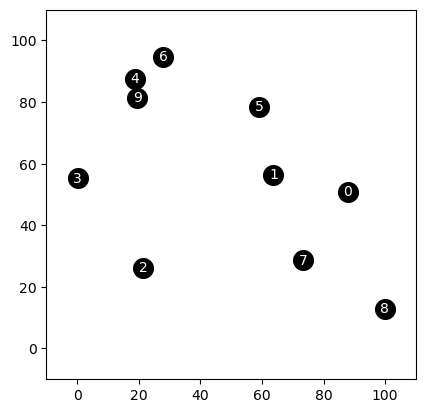

In [94]:
x_positions = []
y_positions = []
labels = []

for sample in ts_trimmed.samples():
    coords = ts_trimmed.individual(ts_trimmed.node(sample).individual).location
    x_positions.append(coords[0])
    y_positions.append(coords[1])
    labels.append(str(sample))

plt.scatter(x_positions, y_positions, s=200, color="black")
for i, txt in enumerate(labels):
    plt.annotate(labels[i], (x_positions[i], y_positions[i]), ha="center", va="center", color="white")
    
plt.axis("square")
plt.xlim(-10, 110)
plt.ylim(-10, 110)
plt.show()

And just like in the discrete space example, we can track lineages over time.

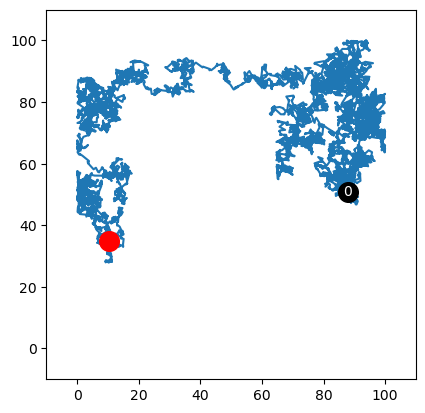

In [91]:
node = 0

nodes = [node]
times = [ts_trimmed.node(node).time]
coords = ts_trimmed.individual(ts_trimmed.node(node).individual).location
x_positions = [coords[0]]
y_positions = [coords[1]]

tree = ts_trimmed.first()
node = tree.parent(node)
while node != -1:
    nodes.append(node)
    times.append(ts_trimmed.node(node).time)
    coords = ts_trimmed.individual(ts_trimmed.node(node).individual).location
    x_positions.append(coords[0])
    y_positions.append(coords[1])
    node = tree.parent(node)

plt.plot(x_positions, y_positions)
plt.scatter(x_positions[0], y_positions[0], s=200, color="black", zorder=2)
plt.scatter(x_positions[-1], y_positions[-1], s=200, color="red", zorder=2)
plt.annotate(nodes[0], (x_positions[0], y_positions[0]), ha="center", va="center", color="white")

plt.axis("square")
plt.xlim(-10, 110)
plt.ylim(-10, 110)
plt.show()

It's often unweildy to deal with all of the unary nodes that do not affect the topology of the graph. The standard `simplify()` from `tskit` removes these nodes, but it also removes some nodes like recombination nodes that can be useful for some spatial analyses. Here's a custom function to return the simplified graph that keeps any nodes affecting topology.

In [96]:
ts_simple, maps_simple = simplify_with_recombination(
    ts=ts_trimmed,
    flag_recomb=True
)

ts_simple.dump("continuous_space_ten_samples.trees")

print(ts_simple.draw_text())

9999.00┊       31            ┊       31            ┊       31            ┊       31            ┊       31            ┊  
       ┊        ┃            ┊        ┃            ┊        ┃            ┊        ┃            ┊        ┃            ┊  
7102.00┊       30            ┊       30            ┊       30            ┊       30            ┊       30            ┊  
       ┊   ┏━━━━┻━━━━┓       ┊   ┏━━━━┻━━━━┓       ┊   ┏━━━━┻━━━━┓       ┊   ┏━━━━┻━━━━┓       ┊   ┏━━━━┻━━━━┓       ┊  
5393.00┊  29         ┃       ┊  29         ┃       ┊  29         ┃       ┊  29         ┃       ┊  29         ┃       ┊  
       ┊   ┃         ┃       ┊   ┃         ┃       ┊   ┃         ┃       ┊   ┃         ┃       ┊   ┃         ┃       ┊  
5381.00┊  27         ┃       ┊  28         ┃       ┊  28         ┃       ┊  28         ┃       ┊  28         ┃       ┊  
       ┊   ┃         ┃       ┊   ┃         ┃       ┊   ┃         ┃       ┊   ┃         ┃       ┊   ┃         ┃       ┊  
4926.00┊  26         ┃       ┊  

...and viewed as a graph!

In [75]:
import tskit_arg_visualizer as argviz

d3arg = argviz.D3ARG.from_ts(ts_simple)
d3arg.draw(width=500, height=500, edge_type="ortho")

To illustrate how this differs from the standard `simplify()`, here is the graph output by that function. Although the overall structure of the graph is similar, the recombination nodes (including "diamonds"/"bubbles") have been removed which changes the edge table. These differences compound for larger, more complex graphs.

In [97]:
d3arg = argviz.D3ARG.from_ts(ts_trimmed.simplify())
d3arg.draw(width=500, height=500)

We can view a coalescent event within the spatial context by tracking two lineages at the same time.

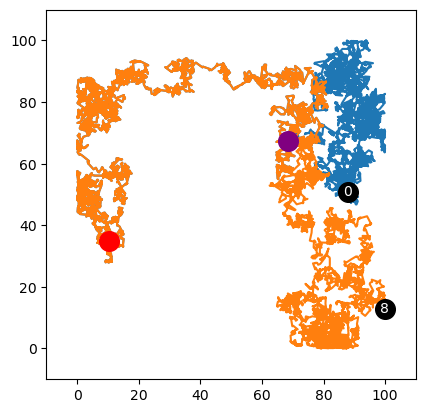

In [98]:
node = 0

nodes = [node]
times = [ts_trimmed.node(node).time]
coords = ts_trimmed.individual(ts_trimmed.node(node).individual).location
x_positions = [coords[0]]
y_positions = [coords[1]]

tree = ts_trimmed.first()
node = tree.parent(node)
while node != -1:
    nodes.append(node)
    times.append(ts_trimmed.node(node).time)
    coords = ts_trimmed.individual(ts_trimmed.node(node).individual).location
    x_positions.append(coords[0])
    y_positions.append(coords[1])
    node = tree.parent(node)

plt.plot(x_positions, y_positions)

plt.scatter(x_positions[0], y_positions[0], s=200, zorder=2, color="black")
plt.annotate(nodes[0], (x_positions[0], y_positions[0]), ha="center", va="center", color="white")


node = 8

nodes = [node]
times = [ts_trimmed.node(node).time]
coords = ts_trimmed.individual(ts_trimmed.node(node).individual).location
x_positions = [coords[0]]
y_positions = [coords[1]]

tree = ts_trimmed.first()
node = tree.parent(node)
while node != -1:
    nodes.append(node)
    times.append(ts_trimmed.node(node).time)
    coords = ts_trimmed.individual(ts_trimmed.node(node).individual).location
    x_positions.append(coords[0])
    y_positions.append(coords[1])
    node = tree.parent(node)

plt.plot(x_positions, y_positions)

plt.scatter(x_positions[0], y_positions[0], s=200, zorder=2, color="black")
plt.annotate(nodes[0], (x_positions[0], y_positions[0]), ha="center", va="center", color="white")
plt.scatter(x_positions[-1], y_positions[-1], s=200, zorder=2, color="red")

plt.scatter(x_positions[4926], y_positions[4926], s=200, zorder=2, color="purple")


plt.axis("square")
plt.xlim(-10, 110)
plt.ylim(-10, 110)
plt.show()